# Hyperparameters and Model Validation

- In the previous section, we saw the basic recipe for applying a supervised machine learning model:

    1. Choose a class of model
    2. Choose model hyperparameters
    3. Fit the model to the training data
    4. Use the model to predict labels for new data


- To choose effective models & parameters, we need a way to *validate* that they are a good fit.

### Model validation the wrong way
- Let's demonstrate the naive approach to validation using the Iris data.

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

- Let's use a *k*-neighbors classifier model with a ``n_neighbors=1`` hyperparameter. This model  says "the label of an unknown point is the same as the label of its closest training point:"

In [15]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

- Train the model & predict it using the labels we already know.

In [16]:
model.fit(X, y)
y_model = model.predict(X)

- How'd we do?

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

- 100% of points were correctly labeled. This approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
- Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

### Model validation the right way: Holdout sets

- This time let's hold back a subset of training data (using the ``train_test_split`` utility), and use it to check the model performance.

In [18]:
#from sklearn.cross_validation import train_test_split -- cross_validation module deprecated
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

model.fit(X1, y1)
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

/home/bjpcjp/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.90666666666666662

- This time the nearest-neighbor classifier is ~90% accurate on the hold-out set. The hold-out set is similar to unknown data, but the model has not "seen" it before.

### Model validation via cross-validation

- Using holdout sets for model validation means you lose part of the training data. This can cause problems – especially if the initial set of training data is small.
- *cross-validation* is a viable alternative. Cross validations use a sequence of fits where each subset of the data is used both as a training set and as a validation set.
- Here's a simple (50/50) visual:
![](figures/05.03-2-fold-CV.png)

- Here's the code:

In [19]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.95999999999999996, 0.90666666666666662)

- This returns two accuracy scores, which we could combine to get a better measure of the model performance. It is called *two-fold cross-validation* (The data is split into two sets and used each in turn.)
- We could use even more trials. Here's a visual depiction of five-fold cross-validation (each group is used to evaluate model fit on the 4/5 of the dataset.)

![](figures/05.03-5-fold-CV.png)
- We can use Scikit-Learn's ``cross_val_score`` convenience routine.

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

- We might want to use a case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial. This is known as *leave-one-out* cross validation.

In [23]:
from sklearn.model_selection import LeaveOneOut
#scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

- Because we have 150 samples, leave-one-out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) predictions. The mean of these gives an estimate of the error rate:

In [24]:
scores.mean()

0.95999999999999996

### Selecting the Best Model

- *if our estimator is underperforming, how should we move forward?* There are several possible answers:

    - Use a more complicated/more flexible model
    - Use a less complicated/less flexible model
    - Gather more training samples
    - Gather more data to add features to each sample

### The Bias-variance trade-off

- The "best model" question is about finding a sweet spot in the tradeoff between *bias* and *variance*. Consider the following figure, which presents two regression fits to the same dataset:

![](figures/05.03-bias-variance.png)

- Neither model is a  good fit to the data - but they fail in different ways.

    - __The model on the left attempts to find a straight-line fit__. Because the data are more complicated than a straight line, the straight-line model will never be able to describe this dataset well. This model *underfits* the data - it does not have enough flexibility to account for all the features in the data. (Another way of saying this is that the model has high *bias*.)

    - __The model on the right attempts to fit a high-order polynomial through the data.__ The model fit has enough flexibility to match features in the data, but its form seems to reflect the noise properties rather than the  properties of whatever process generated that data. This model *overfits* the data - accounting for random errors as well as the underlying data distribution. (Another way of saying this is that the model has high *variance*.)

- Consider what happens if we use these models to predict the y-value for new data. The red/lighter points indicate data that is omitted from the training set.

![](figures/05.03-bias-variance-2.png)

- The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model is no better than the mean of the data, and negative values mean even worse models.

- From these scores we can make an observation:
    - For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
    - For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

- The diagram shown here is often called a *validation curve*.
![](figures/05.03-validation-curve.png)

- Validation curves have the following behaviors:
    - The training score is everywhere higher than the validation score. This is generally true: the model will fit known data better than new data.
    - low-complexity models usually underfit the training data - meaning the model is a poor predictor both for both training data and any previously unseen data.
    - high-complexity models usually overfit the training data - meaning the model predicts training data well, but fails for any previously unseen data.
    - For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

### Validation curves in Scikit-Learn

- Here we use a *polynomial regression* model (a generalized linear model in which the degree of the polynomial is a tunable parameter.) A degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

    $$
    y = ax + b
    $$

- A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

    $$
    y = ax^3 + bx^2 + cx + d
    $$

- We can generalize this to any number of polynomial features.
- We can implement this with a simple linear regression combined with the polynomial preprocessor. We will use a *pipeline* to string these operations together.

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import LinearRegression
from sklearn.pipeline      import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

- Create a dataset.

In [1]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    
    # numpy.ravel() returns a flattened (1D) array.
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

- View the dataset, plus curves representing polynomial regression plots for various degrees.

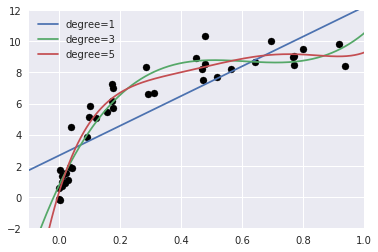

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

- Question: What degree of polynomial provides a suitable bias-variance trade-off?
- We answer this by plotting the validation curve for this data and model. Let's use the ``validation_curve`` method.
- Given a model, data, parameter, and a range, this function will find the training and validation scores across the range.

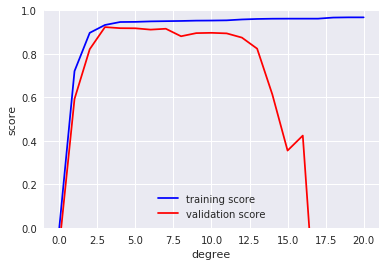

In [28]:
#from sklearn.learning_curve import validation_curve -- deprecated in v0.18
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

- As expected: training score > validation score everywhere, training score improves with increased model complexity;  the validation score reaches a maximum, then suffers from overfit.
- This says the optimal bias/variance trade-off occurs with a third-order polynomial. We can display this fit over the original data too.

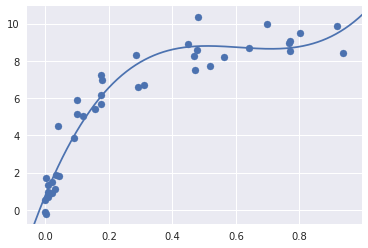

In [29]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

### Learning Curves

- An optimal model will generally depend on the size of the training dataset. Let's generate a new dataset with a factor of five more points:

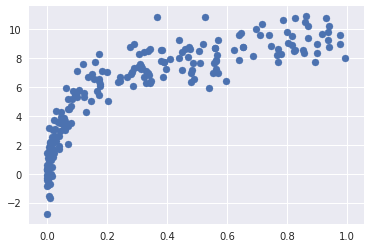

In [30]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

- Plot the validation curve for this larger dataset. (Solid lines.) Let's overlay the previous results for illustration. (Fainter dashed lines.)

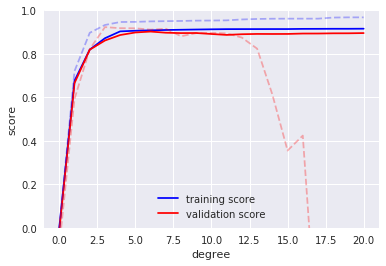

In [31]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1),   color='red',  label='validation score')
plt.plot(degree, np.median(train_score, 1),  color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1),    color='red',  alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

- It looks like the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

- Key lesson: The validation curve has not one but two important inputs: the model complexity and the number of training points. A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

- The general behavior of a learning curve is this:

    - A model of a given complexity will *overfit* a small dataset. (The training score will be relatively high, while the validation score will be relatively low.)
    - A model of a given complexity will *underfit* a large dataset. (The training score will decrease, but the validation score will increase.)
    - A model will never, except by chance, give a better score to the validation set than the training set. The curves should approach each other but never cross.

- With these features in mind, a learning curve should look something like this.

![](figures/05.03-learning-curve.png)

- Notice the convergence to a particular score as the number of training samples grows. Once you have enough points,  *adding more training data will not help you!* (The only way to increase model performance *may be* to use another (often more complex) model.

### Learning curves in Scikit-Learn

-  Build a learning curve for our original dataset with 2nd-order and 9th-order polynomial models.

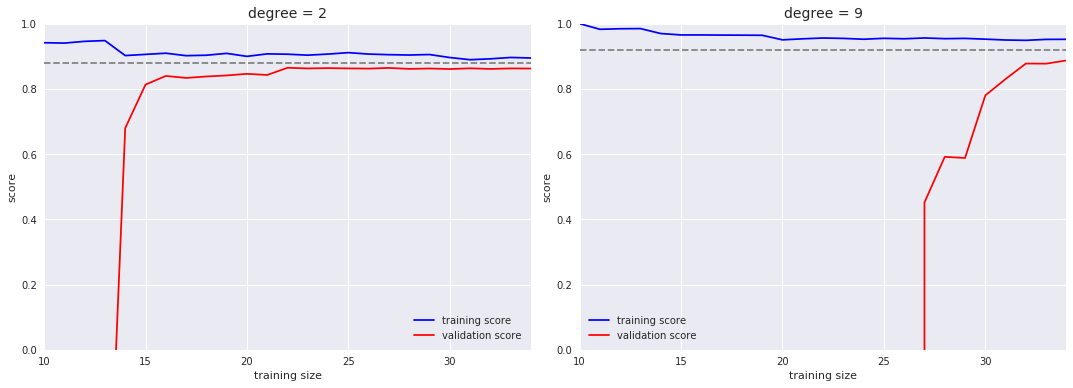

In [32]:
# from sklearn.learning_curve import learning_curve -- deprecated
from sklearn.model_selection import learning_curve


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1),   color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

- This shows how our model responds to increasing training data. When your learning curve has already converged, adding more training data does not help the fit.

- The only way to increase the converged score is to use a different (usually more complicated) model.
- We see this in the right panel: by using a more complicated model, we increase the score of convergence (indicated by the dashed line), but suffer higher variance (the difference between training and validation scores).

## Validation in Practice: Grid Search

- Models typically have multiple "knobs" - therefore their validation and learning curves change from simple curves to multi-dimensional surfaces. These visualizations are difficult - we'd rather just find the model that maximizes the validation score.
- Scikit-Learn provides automated tools, such as grid search, to do this. Let's build a 3D grid of model features (polynomial degree, "fit the intercept?", and "normalize the problem?".) Use Scikit's ``GridSearchCV`` meta-estimator:

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

- Fit the model at each grid point & keep track of the scores.

In [34]:
grid.fit(X, y);

- Which parameters were the "best" fit?

In [35]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

- Use the best model and show the fit to our data.

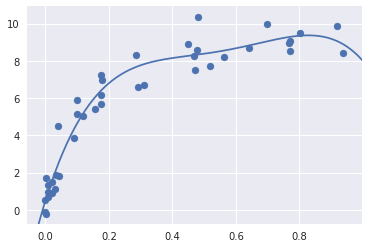

In [36]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
#plt.plot(X_test.ravel(), y_test, hold=True);
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

- The grid search provides multiple options including the ability to specify a scoring function, to parallelize the computations, randomized searches, etc.